Bird call classification (BirdClef)


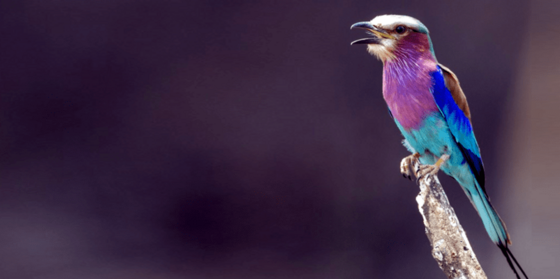

## Data Preparation

In [1]:
!unzip /content/drive/MyDrive/Data/birdclef/birdclef-2024.zip

Streaming output truncated to the last 5000 lines.
  inflating: unlabeled_soundscapes/179981235.ogg  
  inflating: unlabeled_soundscapes/1800082794.ogg  
  inflating: unlabeled_soundscapes/1800832559.ogg  
  inflating: unlabeled_soundscapes/1800923622.ogg  
  inflating: unlabeled_soundscapes/1801340995.ogg  
  inflating: unlabeled_soundscapes/1801365905.ogg  
  inflating: unlabeled_soundscapes/1801959695.ogg  
  inflating: unlabeled_soundscapes/1802029440.ogg  
  inflating: unlabeled_soundscapes/1802100563.ogg  
  inflating: unlabeled_soundscapes/1802118433.ogg  
  inflating: unlabeled_soundscapes/1802137115.ogg  
  inflating: unlabeled_soundscapes/1802619996.ogg  
  inflating: unlabeled_soundscapes/1803065385.ogg  
  inflating: unlabeled_soundscapes/180321934.ogg  
  inflating: unlabeled_soundscapes/1803303477.ogg  
  inflating: unlabeled_soundscapes/1803513714.ogg  
  inflating: unlabeled_soundscapes/1803545829.ogg  
  inflating: unlabeled_soundscapes/1803626967.ogg  
  inflating: un

In [2]:
!pip install torchaudio
!pip install mutagen

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.4/194.4 kB 11.1 MB/s eta 0:00:00


In [3]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchaudio
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import librosa
import librosa.display

In [4]:
!pip install soundfile
!pip install sounddevice


In [5]:
!apt-get install libasound-dev portaudio19-dev libportaudio2 libportaudiocpp0

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'libasound2-dev' instead of 'libasound-dev'
libasound2-dev is already the newest version (1.2.6.1-1ubuntu1).
Suggested packages:
  portaudio19-doc
The following NEW packages will be installed:
  libportaudio2 libportaudiocpp0 portaudio19-dev
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 188 kB of archives.
After this operation, 927 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libportaudio2 amd64 19.6.0-1.1 [65.3 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libportaudiocpp0 amd64 19.6.0-1.1 [16.1 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 portaudio19-dev amd64 19.6.0-1.1 [106 kB]
Fetched 188 kB in 2s (108 kB/s)
Selecting previously unselected package libportaudio2:amd64.
(Reading database ... 123597 files and directories currently installed.)
Preparin

In [6]:
import soundfile as sf
import sounddevice as sd
import numpy as np

import pygame
import IPython.display as display
import os

# Usage
# test file
file_name = '/content/train_audio/asbfly/XC134896.ogg'
display.display(display.Audio(file_name))


pygame 2.6.0 (SDL 2.28.4, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [7]:
from mutagen.oggvorbis import OggVorbis
import numpy as np
import librosa

def read_ogg_properties(file_path):
    audio = OggVorbis(file_path)

    sample_rate = audio.info.sample_rate
    duration = audio.info.length
    num_samples = int(sample_rate * duration)

    return sample_rate, duration, num_samples

def load_ogg_audio(file_path, target_sr=None, target_duration=None):
    # Load audio file
    samples, sr = librosa.load(file_path, sr=target_sr, duration=target_duration)

    # Convert to mono if stereo (librosa.load already handles this by default)
    if len(samples.shape) > 1:
        samples = np.mean(samples, axis=1)

    # Resample if necessary
    if target_sr and target_sr != sr:
        samples = librosa.resample(samples, sr, target_sr)
        sr = target_sr

    # Trim or pad to target duration
    if target_duration:
        target_length = int(target_duration * sr)
        if len(samples) > target_length:
            samples = samples[:target_length]
        else:
            samples = np.pad(samples, (0, target_length - len(samples)))

    return samples, sr

# Example usage
file_path = '/content/train_audio/asbfly/XC134896.ogg'
sample_rate, duration, num_samples = read_ogg_properties(file_path)
print(f"Sample Rate: {sample_rate}")
print(f"Duration: {duration:.2f} seconds")
print(f"Number of Samples: {num_samples}")

# Load audio with specific sample rate and duration
target_sr = 32000
target_duration = 10  # seconds
audio, sr = load_ogg_audio(file_path, target_sr, target_duration)
print(f"Loaded audio shape: {audio.shape}")
print(f"Loaded sample rate: {sr}")

Sample Rate: 32000
Duration: 27.35 seconds
Number of Samples: 875207
Loaded audio shape: (320000,)
Loaded sample rate: 32000


In [8]:
# Constants
SAMPLE_RATE = 32000
DURATION = 10  # seconds
NUM_SAMPLES = SAMPLE_RATE * DURATION

In [9]:
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=1024,
    hop_length=512,
    n_mels=128
)

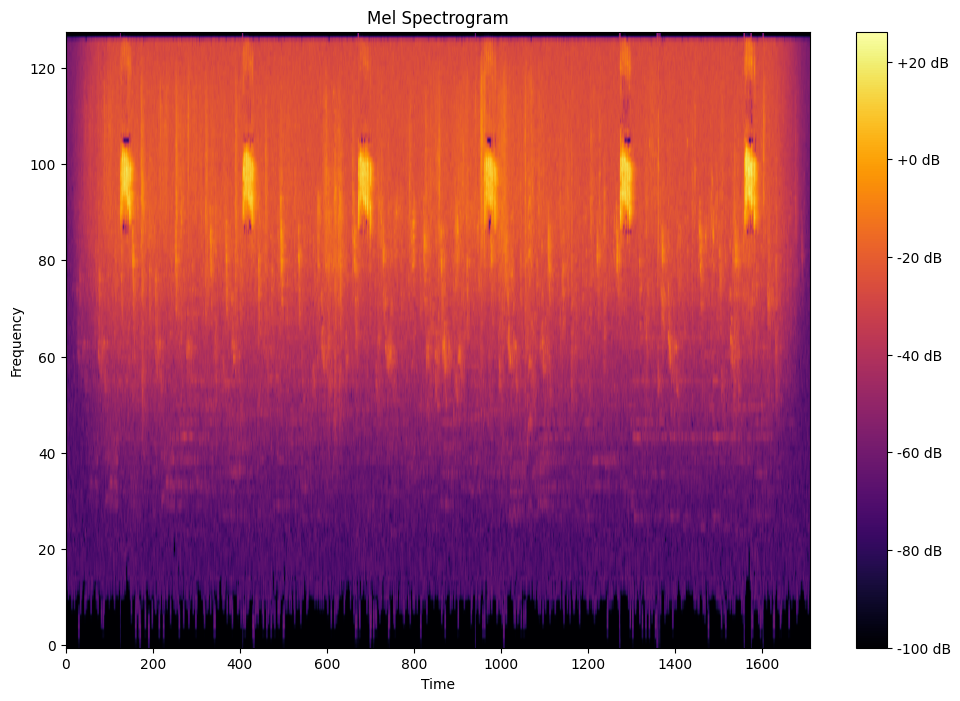

In [10]:
waveform, sr = torchaudio.load(file_name)

# Ensure sample rate matches
assert sr == SAMPLE_RATE, f"Expected sample rate {SAMPLE_RATE}, but got {sr}"

# Apply the mel spectrogram transform
mel_spec = mel_spectrogram(waveform)

# Convert to numpy for plotting
mel_spec_db = torchaudio.transforms.AmplitudeToDB()(mel_spec).numpy()

# Plot the mel spectrogram
plt.figure(figsize=(12, 8))
plt.imshow(mel_spec_db[0], cmap='inferno', origin='lower', aspect='auto')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

In [10]:
class BirdCLEFDataset(Dataset):
    def __init__(self, df, audio_dir, transform=None):
        self.df = df
        self.audio_dir = audio_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        audio_path = os.path.join(self.audio_dir, self.df.iloc[idx]['filename'])
        label = self.df.iloc[idx]['primary_label']

        # Load audio
        waveform, sr = torchaudio.load(audio_path)

        # Resample if necessary
        if sr != SAMPLE_RATE:
            waveform = torchaudio.transforms.Resample(sr, SAMPLE_RATE)(waveform)

        # Convert to mono and cut/pad to 10 seconds
        waveform = waveform.mean(dim=0)
        if waveform.shape[0] > NUM_SAMPLES:
            waveform = waveform[:NUM_SAMPLES]
        else:
            waveform = torch.nn.functional.pad(waveform, (0, NUM_SAMPLES - waveform.shape[0]))

        # Apply mel spectrogram transform
        if self.transform:
            mel_spec = self.transform(waveform)
            mel_spec = mel_spec.unsqueeze(0)
        return mel_spec, label

In [11]:
# Load and preprocess data
df = pd.read_csv('train_metadata.csv')
df['primary_label'] = pd.Categorical(df['primary_label']).codes
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['primary_label'], random_state=42)

# Define transforms
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
      sample_rate=SAMPLE_RATE,
      n_fft=1024,
      hop_length=512,
      n_mels=128
)

# Create datasets and dataloaders
train_dataset = BirdCLEFDataset(train_df, 'train_audio', transform=mel_spectrogram)
val_dataset = BirdCLEFDataset(val_df, 'train_audio', transform=mel_spectrogram)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)


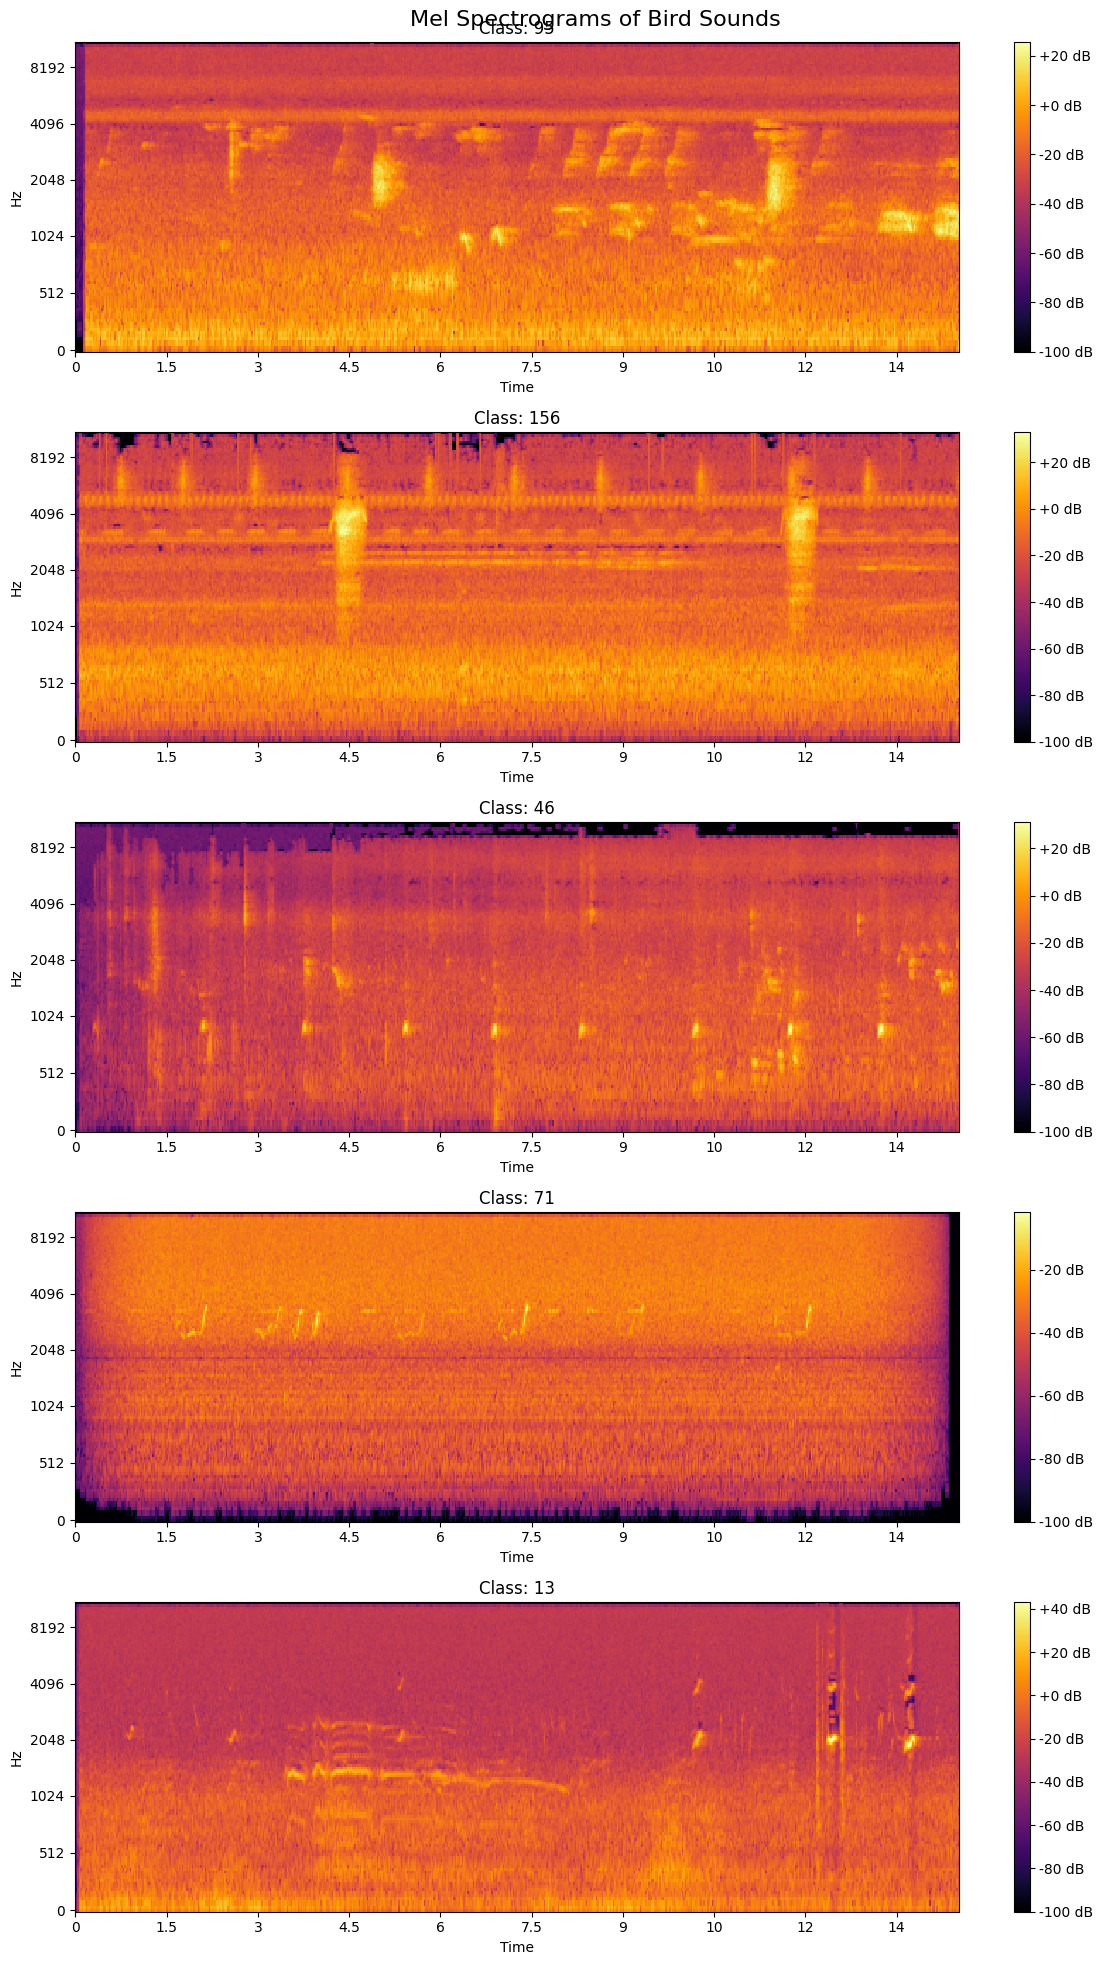

In [ ]:
def visualize_samples(dataset, num_samples=5):
    dataloader = DataLoader(dataset, batch_size=num_samples, shuffle=True)

    # Get a batch of samples
    mel_specs, labels = next(iter(dataloader))

    # Create a figure with subplots
    fig, axes = plt.subplots(num_samples, 1, figsize=(12, 4*num_samples))
    fig.suptitle("Mel Spectrograms of Bird Sounds", fontsize=16)

    for i, (mel_spec, label) in enumerate(zip(mel_specs, labels)):
        # Convert to numpy array and remove batch dimension
        mel_spec = mel_spec.squeeze()

        # Convert to decibels
        mel_spec_db = torchaudio.transforms.AmplitudeToDB()(mel_spec).numpy()

        # Display the mel spectrogram
        img = librosa.display.specshow(mel_spec_db, x_axis='time', y_axis='mel',
                                       ax=axes[i], cmap='inferno')

        axes[i].set_title(f"Class: {label}")
        fig.colorbar(img, ax=axes[i], format="%+2.0f dB")

    plt.tight_layout()
    plt.show()

# Usage
visualize_samples(train_dataset, num_samples=5)

## Modeling Experimentation

Functions to train and evaluate the model

In [12]:
# Training Function
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(dataloader):
        inputs, labels = inputs.to(device), labels.to(device).long()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Evaluation Function
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            inputs, labels = inputs.to(device), labels.to(device).long()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss = running_loss / len(dataloader)
    val_acc = correct / total
    return val_loss, val_acc

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 16 * 78, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        #print(x.shape)
        x = self.pool(torch.relu(self.conv1(x)))
        #print('after conv1')
        #print(x.shape)
        x = self.pool(torch.relu(self.conv2(x)))
        #print('after conv2')
        #print(x.shape)
        x = self.pool(torch.relu(self.conv3(x)))
        #print('after conv3')
        #print(x.shape)
        x = torch.flatten(x, start_dim=1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
# Initialize model, loss, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN(num_classes=len(df['primary_label'].unique())).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

100%|██████████| 153/153 [04:06<00:00,  1.61s/it]


Epoch 1/10:
Train Loss: 5.0389, Train Acc: 0.0311
Val Loss: 4.4799, Val Acc: 0.0487


100%|██████████| 153/153 [04:09<00:00,  1.63s/it]


Epoch 2/10:
Train Loss: 4.4811, Train Acc: 0.0495
Val Loss: 4.3817, Val Acc: 0.0752


100%|██████████| 153/153 [03:59<00:00,  1.57s/it]


Epoch 3/10:
Train Loss: 4.3692, Train Acc: 0.0631
Val Loss: 4.2276, Val Acc: 0.0836


100%|██████████| 153/153 [03:59<00:00,  1.57s/it]


Epoch 4/10:
Train Loss: 4.3041, Train Acc: 0.0735
Val Loss: 4.2261, Val Acc: 0.0842


100%|██████████| 153/153 [04:00<00:00,  1.57s/it]


Epoch 5/10:
Train Loss: 4.2411, Train Acc: 0.0797
Val Loss: 4.1231, Val Acc: 0.1053


100%|██████████| 153/153 [04:06<00:00,  1.61s/it]


Epoch 6/10:
Train Loss: 4.1618, Train Acc: 0.0903
Val Loss: 4.0522, Val Acc: 0.1241


100%|██████████| 153/153 [03:54<00:00,  1.54s/it]


Epoch 7/10:
Train Loss: 4.0871, Train Acc: 0.1028
Val Loss: 3.9981, Val Acc: 0.1263


100%|██████████| 153/153 [04:03<00:00,  1.59s/it]


Epoch 8/10:
Train Loss: 4.0079, Train Acc: 0.1119
Val Loss: 3.9341, Val Acc: 0.1370


100%|██████████| 153/153 [04:03<00:00,  1.59s/it]


Epoch 9/10:
Train Loss: 3.9054, Train Acc: 0.1261
Val Loss: 3.9119, Val Acc: 0.1547


100%|██████████| 153/153 [04:03<00:00,  1.59s/it]

Epoch 10/10:
Train Loss: 3.7682, Train Acc: 0.1458
Val Loss: 3.7650, Val Acc: 0.1596


Let us try transformer models

In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 80.8 MB/s eta 0:00:00


In [ ]:
import os
import torch
import torchaudio
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchaudio.transforms import MelSpectrogram, Resample

class BirdCLEFDataset(Dataset):
    def __init__(self, df, audio_dir, transform=None):
        self.df = df
        self.audio_dir = audio_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        audio_path = os.path.join(self.audio_dir, self.df.iloc[idx]['filename'])
        label = self.df.iloc[idx]['primary_label']

        # Load audio
        waveform, sr = torchaudio.load(audio_path)

        # Resample if necessary
        if sr != SAMPLE_RATE:
            waveform = Resample(sr, SAMPLE_RATE)(waveform)

        # Convert to mono and cut/pad to 10 seconds
        waveform = waveform.mean(dim=0)
        if waveform.shape[0] > NUM_SAMPLES:
            waveform = waveform[:NUM_SAMPLES]
        else:
            waveform = torch.nn.functional.pad(waveform, (0, NUM_SAMPLES - waveform.shape[0]))

        # Apply mel spectrogram transform
        if self.transform:
            mel_spec = self.transform(waveform)
        else:
            # Default mel spectrogram transformation
            mel_spec = MelSpectrogram(
                sample_rate=SAMPLE_RATE,
                n_mels=128,
                n_fft=2048,
                hop_length=512,
                power=2.0
            )(waveform)

        # Ensure mel_spec has correct dimensions (N, C, H, W)
        if mel_spec.ndim == 2:
            mel_spec = mel_spec.unsqueeze(0)  # Add channel dimension if needed

        # Resize mel spectrogram to 224x224
        if mel_spec.size(1) != 224 or mel_spec.size(2) != 224:
            mel_spec = F.interpolate(mel_spec.unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False)

        return mel_spec.squeeze(0), label  # Remove batch dimension before returning


In [ ]:
mel_spectrogram_transform = torchaudio.transforms.MelSpectrogram(
        sample_rate=SAMPLE_RATE,
        n_mels=128,
        n_fft=2048,
        hop_length=512,
        power=2.0
    )

In [ ]:
train_dataset = BirdCLEFDataset(train_df, 'train_audio', transform=mel_spectrogram_transform)
val_dataset = BirdCLEFDataset(val_df, 'train_audio', transform=mel_spectrogram_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm

class Swin_Model(nn.Module):
    def __init__(self, num_classes):
        super(Swin_Model, self).__init__()
        self.swin_transformer = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True)
        self.swin_transformer.head = nn.Identity()  # Remove the original head
        self.channel_adjuster = nn.Conv2d(1, 3, kernel_size=1)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))  # Global Average Pooling
        self.fc = nn.Linear(7, num_classes)  # 182 is the number of channels in your output

    def forward(self, x):
        #print(x.shape)
        x = self.channel_adjuster(x)
        #print(x.shape)
        # Reshape the output to fit Swin Transformer input dimensions
        x = x.permute(0, 3, 2, 1)  # (batch_size, height, width, channels)
        x = x.contiguous().view(x.size(0), x.size(1), x.size(2), -1).permute(0, 3, 2, 1)  # (batch_size, channels, height, width)

        x = self.swin_transformer(x)  # Get feature maps
        x = self.global_avg_pool(x)   # Apply global average pooling
        x = torch.flatten(x, 1)       # Flatten the tensor (batch_size, num_features)
        x = self.fc(x)                # Apply the classification head
        return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Swin_Model(num_classes=len(df['primary_label'].unique())).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

100%|██████████| 306/306 [01:20<00:00,  3.79it/s]


Epoch 1/10:
Train Loss: 5.1936, Train Acc: 0.0145
Val Loss: 5.0892, Val Acc: 0.0204


100%|██████████| 306/306 [01:18<00:00,  3.89it/s]


Epoch 2/10:
Train Loss: 4.9779, Train Acc: 0.0204
Val Loss: 4.8712, Val Acc: 0.0204


100%|██████████| 306/306 [01:17<00:00,  3.95it/s]


Epoch 3/10:
Train Loss: 4.7987, Train Acc: 0.0204
Val Loss: 4.7370, Val Acc: 0.0204


100%|██████████| 306/306 [01:17<00:00,  3.97it/s]


Epoch 4/10:
Train Loss: 4.7068, Train Acc: 0.0204
Val Loss: 4.6788, Val Acc: 0.0204


100%|██████████| 306/306 [01:17<00:00,  3.93it/s]


Epoch 5/10:
Train Loss: 4.6694, Train Acc: 0.0204
Val Loss: 4.6560, Val Acc: 0.0204


100%|██████████| 306/306 [01:17<00:00,  3.95it/s]


Epoch 6/10:
Train Loss: 4.6548, Train Acc: 0.0200
Val Loss: 4.6468, Val Acc: 0.0204


100%|██████████| 306/306 [01:17<00:00,  3.95it/s]


Epoch 7/10:
Train Loss: 4.6485, Train Acc: 0.0191
Val Loss: 4.6426, Val Acc: 0.0204


100%|██████████| 306/306 [01:16<00:00,  4.01it/s]


Epoch 8/10:
Train Loss: 4.6456, Train Acc: 0.0191
Val Loss: 4.6405, Val Acc: 0.0204


100%|██████████| 306/306 [01:17<00:00,  3.93it/s]


Epoch 9/10:
Train Loss: 4.6439, Train Acc: 0.0186
Val Loss: 4.6392, Val Acc: 0.0204


100%|██████████| 306/306 [01:17<00:00,  3.95it/s]

Epoch 10/10:
Train Loss: 4.6430, Train Acc: 0.0180
Val Loss: 4.6384, Val Acc: 0.0204


That was a commercial failure, let us try LSTM

In [34]:
import gc
torch.cuda.empty_cache()
gc.collect()


0

In [ ]:
class BirdCLEFDataset(Dataset):
    def __init__(self, df, audio_dir, transform=None):
        self.df = df
        self.audio_dir = audio_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        audio_path = os.path.join(self.audio_dir, self.df.iloc[idx]['filename'])
        label = self.df.iloc[idx]['primary_label']

        # Load audio
        waveform, sr = torchaudio.load(audio_path)

        # Resample if necessary
        if sr != SAMPLE_RATE:
            waveform = torchaudio.transforms.Resample(sr, SAMPLE_RATE)(waveform)

        # Convert to mono and cut/pad to 10 seconds
        waveform = waveform.mean(dim=0)
        if waveform.shape[0] > NUM_SAMPLES:
            waveform = waveform[:NUM_SAMPLES]
        else:
            waveform = torch.nn.functional.pad(waveform, (0, NUM_SAMPLES - waveform.shape[0]))

        # Apply mel spectrogram transform
        if self.transform:
            mel_spec = self.transform(waveform)
            mel_spec = mel_spec.unsqueeze(0)
        return mel_spec, label

In [37]:
# Define transforms
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
      sample_rate=SAMPLE_RATE,
      n_fft=1024,
      hop_length=512,
      n_mels=128
)

# Create datasets and dataloaders
train_dataset = BirdCLEFDataset(train_df, 'train_audio', transform=mel_spectrogram)
val_dataset = BirdCLEFDataset(val_df, 'train_audio', transform=mel_spectrogram)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)


In [38]:
class AudioLSTM(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dim=128, num_layers=2):
        super(AudioLSTM, self).__init__()
        self.cnn = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.lstm = nn.LSTM(64, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim*2, num_classes)

    def forward(self, x):
        x = self.pool(self.cnn(x))
        # Reshape for RNN
        batch_size, channels, height, width = x.size()
        x = x.permute(0, 2, 3, 1)
        x = x.reshape(batch_size, height * width, channels)
        x = x.contiguous()
        x, _ = self.lstm(x)
        x = self.fc(x[:,-1,:])  # Take the last output for classification
        return x


In [39]:
# Initialize model, criterion, and optimizer
input_size = 1  # Update to match flattened dimensions
model = AudioLSTM(input_size, num_classes=len(df['primary_label'].unique())).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)

# Training
num_epochs = 10
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

100%|██████████| 306/306 [01:46<00:00,  2.87it/s]


Epoch 1/10:
Train Loss: 4.6824, Train Acc: 0.0199
Val Loss: 4.6517, Val Acc: 0.0204


100%|██████████| 306/306 [01:46<00:00,  2.87it/s]


Epoch 2/10:
Train Loss: 4.6510, Train Acc: 0.0213
Val Loss: 4.6378, Val Acc: 0.0221


100%|██████████| 306/306 [01:45<00:00,  2.91it/s]


Epoch 3/10:
Train Loss: 4.6397, Train Acc: 0.0220
Val Loss: 4.6444, Val Acc: 0.0206


100%|██████████| 306/306 [01:46<00:00,  2.89it/s]


Epoch 4/10:
Train Loss: 4.6352, Train Acc: 0.0222
Val Loss: 4.6247, Val Acc: 0.0215


100%|██████████| 306/306 [01:46<00:00,  2.88it/s]


Epoch 5/10:
Train Loss: 4.6133, Train Acc: 0.0231
Val Loss: 4.6228, Val Acc: 0.0258


100%|██████████| 306/306 [01:45<00:00,  2.89it/s]


Epoch 6/10:
Train Loss: 4.6045, Train Acc: 0.0255
Val Loss: 4.6016, Val Acc: 0.0278


100%|██████████| 306/306 [01:46<00:00,  2.88it/s]


Epoch 7/10:
Train Loss: 4.5915, Train Acc: 0.0275
Val Loss: 4.6044, Val Acc: 0.0249


100%|██████████| 306/306 [01:46<00:00,  2.87it/s]


Epoch 8/10:
Train Loss: 4.5635, Train Acc: 0.0310
Val Loss: 4.5548, Val Acc: 0.0247


100%|██████████| 306/306 [01:46<00:00,  2.87it/s]


Epoch 9/10:
Train Loss: 4.5406, Train Acc: 0.0314
Val Loss: 4.4926, Val Acc: 0.0392


100%|██████████| 306/306 [01:46<00:00,  2.88it/s]

Epoch 10/10:
Train Loss: 4.4827, Train Acc: 0.0401
Val Loss: 4.6456, Val Acc: 0.0172


That failed, let us try with pretrained models

In [ ]:
from torchvision.models import resnet18
import torch
import torch.nn as nn
import torchvision.models as models

class AudioResNet18(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(AudioResNet18, self).__init__()
        self.model = models.resnet18(pretrained=pretrained)

        # Modify the first convolution layer to accept 1 channel (for Mel spectrogram)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Modify the final fully connected layer to output the number of classes
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AudioResNet18(num_classes=len(df['primary_label'].unique())).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 153/153 [01:10<00:00,  2.16it/s]


Epoch 1/10:
Train Loss: 3.7739, Train Acc: 0.2070
Val Loss: 3.2518, Val Acc: 0.2964


100%|██████████| 153/153 [01:08<00:00,  2.24it/s]


Epoch 2/10:
Train Loss: 2.4473, Train Acc: 0.4539
Val Loss: 3.1323, Val Acc: 0.3095


100%|██████████| 153/153 [01:08<00:00,  2.23it/s]


Epoch 3/10:
Train Loss: 1.8765, Train Acc: 0.5720
Val Loss: 2.3381, Val Acc: 0.4789


100%|██████████| 153/153 [01:11<00:00,  2.15it/s]


Epoch 4/10:
Train Loss: 1.4906, Train Acc: 0.6557
Val Loss: 2.4622, Val Acc: 0.4481


100%|██████████| 153/153 [01:10<00:00,  2.18it/s]


Epoch 5/10:
Train Loss: 1.1840, Train Acc: 0.7255
Val Loss: 2.6608, Val Acc: 0.4203


100%|██████████| 153/153 [01:09<00:00,  2.20it/s]


Epoch 6/10:
Train Loss: 0.9236, Train Acc: 0.7877
Val Loss: 2.2503, Val Acc: 0.4969


100%|██████████| 153/153 [01:08<00:00,  2.24it/s]


Epoch 7/10:
Train Loss: 0.6926, Train Acc: 0.8457
Val Loss: 1.6075, Val Acc: 0.6314


100%|██████████| 153/153 [01:11<00:00,  2.13it/s]


Epoch 8/10:
Train Loss: 0.4981, Train Acc: 0.8956
Val Loss: 3.4565, Val Acc: 0.3653


100%|██████████| 153/153 [01:09<00:00,  2.20it/s]


Epoch 9/10:
Train Loss: 0.3380, Train Acc: 0.9328
Val Loss: 2.5197, Val Acc: 0.4736


100%|██████████| 153/153 [01:09<00:00,  2.19it/s]

Epoch 10/10:
Train Loss: 0.2445, Train Acc: 0.9544
Val Loss: 1.9293, Val Acc: 0.5848


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class ResNeXtForAudio(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(ResNeXtForAudio, self).__init__()

        # Load ResNeXt model
        self.resnext = models.resnext50_32x4d(pretrained=pretrained)

        # Modify the first convolution layer to accept 1 channel (for Mel spectrogram)
        self.resnext.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Remove the final classification layer
        self.resnext.fc = nn.Linear(self.resnext.fc.in_features, num_classes)

    def forward(self, x):
        x = self.resnext(x)
        return x


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNeXtForAudio(num_classes=len(df['primary_label'].unique())).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 199MB/s]
100%|██████████| 153/153 [01:11<00:00,  2.14it/s]


Epoch 1/10:
Train Loss: 3.2197, Train Acc: 0.3080
Val Loss: 2.6303, Val Acc: 0.4215


100%|██████████| 153/153 [01:12<00:00,  2.12it/s]


Epoch 2/10:
Train Loss: 1.9236, Train Acc: 0.5598
Val Loss: 2.1084, Val Acc: 0.5298


100%|██████████| 153/153 [01:12<00:00,  2.12it/s]


Epoch 3/10:
Train Loss: 1.3795, Train Acc: 0.6763
Val Loss: 1.7848, Val Acc: 0.5879


100%|██████████| 153/153 [01:11<00:00,  2.13it/s]


Epoch 4/10:
Train Loss: 1.0261, Train Acc: 0.7536
Val Loss: 1.6898, Val Acc: 0.6212


100%|██████████| 153/153 [01:12<00:00,  2.10it/s]


Epoch 5/10:
Train Loss: 0.7350, Train Acc: 0.8190
Val Loss: 1.7026, Val Acc: 0.6235


100%|██████████| 153/153 [01:13<00:00,  2.08it/s]


Epoch 6/10:
Train Loss: 0.4973, Train Acc: 0.8761
Val Loss: 1.6762, Val Acc: 0.6408


100%|██████████| 153/153 [01:11<00:00,  2.14it/s]


Epoch 7/10:
Train Loss: 0.3284, Train Acc: 0.9199
Val Loss: 1.8047, Val Acc: 0.6274


100%|██████████| 153/153 [01:12<00:00,  2.12it/s]


Epoch 8/10:
Train Loss: 0.2200, Train Acc: 0.9468
Val Loss: 2.1718, Val Acc: 0.5664


100%|██████████| 153/153 [01:12<00:00,  2.12it/s]


Epoch 9/10:
Train Loss: 0.1766, Train Acc: 0.9559
Val Loss: 1.8148, Val Acc: 0.6357


100%|██████████| 153/153 [01:11<00:00,  2.15it/s]

Epoch 10/10:
Train Loss: 0.1766, Train Acc: 0.9567
Val Loss: 2.1077, Val Acc: 0.5951


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class SENetForAudio(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(SENetForAudio, self).__init__()

        # Load SE-ResNet model
        self.senet = models.squeezenet1_0(pretrained=pretrained)

        # Modify the first convolution layer to accept 1 channel (for Mel spectrogram)
        self.senet.features[0] = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Modify the Fire module's first convolution layer in features[3]
        # to accept 64 channels from the previous layer
        self.senet.features[3].squeeze = nn.Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))

        # Remove the final classification layer and replace with a new one
        self.senet.classifier = nn.Sequential(
            nn.Dropout(p=0.5, inplace=False),
            nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1)),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(output_size=(1, 1))
        )

    def forward(self, x):
        x = self.senet(x)
        return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SENetForAudio(num_classes=len(df['primary_label'].unique())).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 153/153 [01:08<00:00,  2.22it/s]


Epoch 1/10:
Train Loss: 4.8353, Train Acc: 0.0392
Val Loss: 4.4464, Val Acc: 0.0685


100%|██████████| 153/153 [01:05<00:00,  2.32it/s]


Epoch 2/10:
Train Loss: 4.2884, Train Acc: 0.0962
Val Loss: 4.1608, Val Acc: 0.1171


100%|██████████| 153/153 [01:07<00:00,  2.25it/s]


Epoch 3/10:
Train Loss: 3.9477, Train Acc: 0.1543
Val Loss: 3.7978, Val Acc: 0.1870


100%|██████████| 153/153 [01:06<00:00,  2.30it/s]


Epoch 4/10:
Train Loss: 3.6070, Train Acc: 0.2159
Val Loss: 3.4640, Val Acc: 0.2596


100%|██████████| 153/153 [01:08<00:00,  2.24it/s]


Epoch 5/10:
Train Loss: 3.3250, Train Acc: 0.2729
Val Loss: 3.2746, Val Acc: 0.2878


100%|██████████| 153/153 [01:06<00:00,  2.32it/s]


Epoch 6/10:
Train Loss: 3.0702, Train Acc: 0.3191
Val Loss: 3.0379, Val Acc: 0.3414


100%|██████████| 153/153 [01:07<00:00,  2.27it/s]


Epoch 7/10:
Train Loss: 2.8441, Train Acc: 0.3589
Val Loss: 2.8170, Val Acc: 0.3808


100%|██████████| 153/153 [01:08<00:00,  2.24it/s]


Epoch 8/10:
Train Loss: 2.6512, Train Acc: 0.4031
Val Loss: 2.7645, Val Acc: 0.3949


100%|██████████| 153/153 [01:07<00:00,  2.26it/s]


Epoch 9/10:
Train Loss: 2.4879, Train Acc: 0.4409
Val Loss: 2.5817, Val Acc: 0.4311


100%|██████████| 153/153 [01:08<00:00,  2.24it/s]

Epoch 10/10:
Train Loss: 2.3606, Train Acc: 0.4646
Val Loss: 2.4519, Val Acc: 0.4593


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class DenseNetForAudio(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(DenseNetForAudio, self).__init__()

        # Load DenseNet model
        self.densenet = models.densenet121(pretrained=pretrained)

        # Modify the first convolution layer to accept 1 channel (for Mel spectrogram)
        self.densenet.features.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Remove the final classification layer
        self.densenet.classifier = nn.Linear(self.densenet.classifier.in_features, num_classes)

    def forward(self, x):
        x = self.densenet(x)
        return x


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DenseNetForAudio(num_classes=len(df['primary_label'].unique())).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 144MB/s]
100%|██████████| 153/153 [01:11<00:00,  2.14it/s]


Epoch 1/10:
Train Loss: 3.5496, Train Acc: 0.2646
Val Loss: 3.0437, Val Acc: 0.3418


100%|██████████| 153/153 [01:10<00:00,  2.18it/s]


Epoch 2/10:
Train Loss: 2.2714, Train Acc: 0.5016
Val Loss: 2.1695, Val Acc: 0.5268


100%|██████████| 153/153 [01:12<00:00,  2.12it/s]


Epoch 3/10:
Train Loss: 1.7203, Train Acc: 0.6150
Val Loss: 2.4265, Val Acc: 0.4759


100%|██████████| 153/153 [01:11<00:00,  2.13it/s]


Epoch 4/10:
Train Loss: 1.3774, Train Acc: 0.6825
Val Loss: 2.0059, Val Acc: 0.5462


100%|██████████| 153/153 [01:10<00:00,  2.16it/s]


Epoch 5/10:
Train Loss: 1.1022, Train Acc: 0.7450
Val Loss: 1.8053, Val Acc: 0.5885


100%|██████████| 153/153 [01:08<00:00,  2.23it/s]


Epoch 6/10:
Train Loss: 0.8907, Train Acc: 0.7918
Val Loss: 1.9466, Val Acc: 0.5695


100%|██████████| 153/153 [01:09<00:00,  2.21it/s]


Epoch 7/10:
Train Loss: 0.6986, Train Acc: 0.8357
Val Loss: 1.9118, Val Acc: 0.5781


100%|██████████| 153/153 [01:09<00:00,  2.21it/s]


Epoch 8/10:
Train Loss: 0.5377, Train Acc: 0.8760
Val Loss: 1.9084, Val Acc: 0.5738


100%|██████████| 153/153 [01:11<00:00,  2.15it/s]


Epoch 9/10:
Train Loss: 0.4105, Train Acc: 0.9040
Val Loss: 1.8286, Val Acc: 0.6000


100%|██████████| 153/153 [01:09<00:00,  2.20it/s]

Epoch 10/10:
Train Loss: 0.3109, Train Acc: 0.9329
Val Loss: 1.9804, Val Acc: 0.5834


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class EfficientNetForAudio(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(EfficientNetForAudio, self).__init__()

        # Load EfficientNet model
        self.efficientnet = models.efficientnet_b0(pretrained=pretrained)

        # Modify the first convolution layer to accept 1 channel (for Mel spectrogram)
        self.efficientnet.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)

        # Access the final linear layer's input features
        num_features = self.efficientnet.classifier[1].in_features

        # Replace the final classification layer
        self.efficientnet.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(num_features, num_classes)
        )

    def forward(self, x):
        x = self.efficientnet(x)
        return x


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EfficientNetForAudio(num_classes=len(df['primary_label'].unique())).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

100%|██████████| 306/306 [01:16<00:00,  3.98it/s]


Epoch 1/10:
Train Loss: 3.7660, Train Acc: 0.1990
Val Loss: 2.8576, Val Acc: 0.3401


100%|██████████| 306/306 [01:11<00:00,  4.28it/s]


Epoch 2/10:
Train Loss: 2.5729, Train Acc: 0.4098
Val Loss: 2.5068, Val Acc: 0.4191


100%|██████████| 306/306 [01:12<00:00,  4.19it/s]


Epoch 3/10:
Train Loss: 2.0627, Train Acc: 0.5123
Val Loss: 2.3591, Val Acc: 0.4638


100%|██████████| 306/306 [01:10<00:00,  4.35it/s]


Epoch 4/10:
Train Loss: 1.7375, Train Acc: 0.5817
Val Loss: 2.4840, Val Acc: 0.4573


100%|██████████| 306/306 [01:11<00:00,  4.29it/s]


Epoch 5/10:
Train Loss: 1.4950, Train Acc: 0.6348
Val Loss: 2.1589, Val Acc: 0.5362


100%|██████████| 306/306 [01:11<00:00,  4.25it/s]


Epoch 6/10:
Train Loss: 1.3062, Train Acc: 0.6769
Val Loss: 2.5350, Val Acc: 0.4826


100%|██████████| 306/306 [01:10<00:00,  4.32it/s]


Epoch 7/10:
Train Loss: 1.1482, Train Acc: 0.7114
Val Loss: 2.1559, Val Acc: 0.5407


100%|██████████| 306/306 [01:11<00:00,  4.26it/s]


Epoch 8/10:
Train Loss: 1.0022, Train Acc: 0.7461
Val Loss: 2.0915, Val Acc: 0.5509


100%|██████████| 306/306 [01:11<00:00,  4.29it/s]


Epoch 9/10:
Train Loss: 0.8824, Train Acc: 0.7746
Val Loss: 2.1393, Val Acc: 0.5292


100%|██████████| 306/306 [01:09<00:00,  4.38it/s]

Epoch 10/10:
Train Loss: 0.7675, Train Acc: 0.7982
Val Loss: 2.1615, Val Acc: 0.5397


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class MobileNetAudioClassifier(nn.Module):
    def __init__(self, num_classes, input_channels=1, hidden_size=128, num_layers=2):
        super(MobileNetAudioClassifier, self).__init__()

        # Load pre-trained MobileNetV2 and modify the first conv layer
        self.mobilenet = models.mobilenet_v2(pretrained=True)
        self.mobilenet.features[0][0] = nn.Conv2d(input_channels, 32, kernel_size=3, stride=2, padding=1, bias=False)

    def forward(self, x):
        # Extract features using MobileNet
        x = self.mobilenet(x)
        return x


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MobileNetAudioClassifier(num_classes=len(df['primary_label'].unique())).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 306/306 [01:12<00:00,  4.23it/s]


Epoch 1/10:
Train Loss: 3.8484, Train Acc: 0.2247
Val Loss: 3.1474, Val Acc: 0.3260


100%|██████████| 306/306 [01:11<00:00,  4.30it/s]


Epoch 2/10:
Train Loss: 2.4310, Train Acc: 0.4564
Val Loss: 2.7131, Val Acc: 0.4176


100%|██████████| 306/306 [01:11<00:00,  4.27it/s]


Epoch 3/10:
Train Loss: 1.8752, Train Acc: 0.5613
Val Loss: 1.9321, Val Acc: 0.5662


100%|██████████| 306/306 [01:10<00:00,  4.35it/s]


Epoch 4/10:
Train Loss: 1.5439, Train Acc: 0.6286
Val Loss: 2.6148, Val Acc: 0.4761


100%|██████████| 306/306 [01:10<00:00,  4.36it/s]


Epoch 5/10:
Train Loss: 1.3120, Train Acc: 0.6766
Val Loss: 1.8465, Val Acc: 0.5861


100%|██████████| 306/306 [01:08<00:00,  4.44it/s]


Epoch 6/10:
Train Loss: 1.1077, Train Acc: 0.7227
Val Loss: 2.0141, Val Acc: 0.5697


100%|██████████| 306/306 [01:09<00:00,  4.39it/s]


Epoch 7/10:
Train Loss: 0.9395, Train Acc: 0.7613
Val Loss: 2.3230, Val Acc: 0.5313


100%|██████████| 306/306 [01:10<00:00,  4.32it/s]


Epoch 8/10:
Train Loss: 0.8095, Train Acc: 0.7883
Val Loss: 2.4289, Val Acc: 0.5525


100%|██████████| 306/306 [01:10<00:00,  4.36it/s]


Epoch 9/10:
Train Loss: 0.6873, Train Acc: 0.8183
Val Loss: 2.2255, Val Acc: 0.5593


100%|██████████| 306/306 [01:09<00:00,  4.43it/s]

Epoch 10/10:
Train Loss: 0.5876, Train Acc: 0.8422
Val Loss: 2.1469, Val Acc: 0.5863


Audio has sequential component in it. Let us try with combination of these CNN models, LSTM & Attention

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNRNNAttention(nn.Module):
    def __init__(self, num_classes, input_channels=1, hidden_size=128, num_layers=2, dropout_rnn = 0.0, dropout_cnn = 0.0):
        super(CNNRNNAttention, self).__init__()

        # CNN layers
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # RNN layers
        self.rnn = nn.LSTM(256, hidden_size, num_layers, batch_first=True, bidirectional=True)

        # Dropout layers
        self.dropout_rnn = nn.Dropout(dropout_rnn)
        self.dropout_cnn = nn.Dropout(dropout_cnn)

        # Attention layer
        self.attention = nn.Linear(hidden_size * 2, 1)

        # Output layer
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        # CNN feature extraction
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

         # Apply dropout
        x = self.dropout_cnn(x)

        # Reshape for RNN
        batch_size, channels, height, width = x.size()
        x = x.permute(0, 2, 3, 1)
        x = x.reshape(batch_size, height * width, channels)



        # RNN processing
        rnn_out, _ = self.rnn(x)

        # Apply dropout after RNN
        rnn_out = self.dropout_rnn(rnn_out)

        # Attention mechanism
        attention_weights = F.softmax(self.attention(rnn_out), dim=1)
        context_vector = torch.sum(attention_weights * rnn_out, dim=1)

        # Classification
        output = self.fc(context_vector)
        return output

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNRNNAttention(num_classes=len(df['primary_label'].unique())).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training
num_epochs = 10
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

100%|██████████| 153/153 [01:15<00:00,  2.03it/s]


Epoch 1/10:
Train Loss: 4.6542, Train Acc: 0.0228
Val Loss: 4.5255, Val Acc: 0.0292


100%|██████████| 153/153 [01:17<00:00,  1.97it/s]


Epoch 2/10:
Train Loss: 4.2940, Train Acc: 0.0778
Val Loss: 4.0013, Val Acc: 0.1173


100%|██████████| 153/153 [01:14<00:00,  2.04it/s]


Epoch 3/10:
Train Loss: 3.6929, Train Acc: 0.1767
Val Loss: 3.4867, Val Acc: 0.2177


100%|██████████| 153/153 [01:14<00:00,  2.05it/s]


Epoch 4/10:
Train Loss: 3.3208, Train Acc: 0.2492
Val Loss: 3.1750, Val Acc: 0.2866


100%|██████████| 153/153 [01:15<00:00,  2.02it/s]


Epoch 5/10:
Train Loss: 3.1215, Train Acc: 0.2883
Val Loss: 3.0470, Val Acc: 0.3160


100%|██████████| 153/153 [01:13<00:00,  2.07it/s]


Epoch 6/10:
Train Loss: 2.9147, Train Acc: 0.3368
Val Loss: 2.9827, Val Acc: 0.3211


100%|██████████| 153/153 [01:16<00:00,  2.00it/s]


Epoch 7/10:
Train Loss: 2.7618, Train Acc: 0.3619
Val Loss: 2.8313, Val Acc: 0.3587


100%|██████████| 153/153 [01:13<00:00,  2.07it/s]


Epoch 8/10:
Train Loss: 2.6162, Train Acc: 0.3914
Val Loss: 2.5876, Val Acc: 0.4064


100%|██████████| 153/153 [01:16<00:00,  2.01it/s]


Epoch 9/10:
Train Loss: 2.4319, Train Acc: 0.4305
Val Loss: 2.4891, Val Acc: 0.4307


100%|██████████| 153/153 [01:14<00:00,  2.06it/s]

Epoch 10/10:
Train Loss: 2.3252, Train Acc: 0.4509
Val Loss: 2.4323, Val Acc: 0.4475


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F

class ResNetLSTMAttention(nn.Module):
    def __init__(self, num_classes, hidden_size=128, num_layers=2, dropout=0.5, pretrained=True):
        super(ResNetLSTMAttention, self).__init__()

        # Load the pretrained ResNet model
        self.resnet = models.resnet18(pretrained=pretrained)

        # Modify the first convolution layer to accept 1 channel (for Mel spectrogram)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Remove the fully connected layer
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-2])

        # LSTM layer
        self.lstm = nn.LSTM(input_size=512, hidden_size=hidden_size, num_layers=num_layers,
                            batch_first=True, bidirectional=True, dropout=dropout)

        # Attention layer
        self.attention = nn.Linear(hidden_size * 2, 1)

        # Fully connected layer for classification
        self.fc = nn.Linear(hidden_size * 2, num_classes)

        # Dropout layer
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Pass through ResNet to extract features
        batch_size = x.size(0)
        cnn_features = self.resnet(x)

        # Reshape for LSTM
        cnn_features = cnn_features.permute(0, 2, 3, 1)  # Change shape to [batch_size, height, width, channels]
        cnn_features = cnn_features.view(batch_size, -1, 512)  # Flatten height and width into one dimension

        # Pass through LSTM
        lstm_out, _ = self.lstm(cnn_features)

        # Apply attention mechanism
        attention_weights = F.softmax(self.attention(lstm_out), dim=1)
        context_vector = torch.sum(attention_weights * lstm_out, dim=1)

        # Apply dropout
        context_vector = self.dropout(context_vector)

        # Pass through the final fully connected layer
        output = self.fc(context_vector)
        return output


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNetLSTMAttention(num_classes=len(df['primary_label'].unique())).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training
num_epochs = 10
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

100%|██████████| 153/153 [01:08<00:00,  2.22it/s]


Epoch 1/10:
Train Loss: 4.5411, Train Acc: 0.0385
Val Loss: 4.1271, Val Acc: 0.0744


100%|██████████| 153/153 [01:08<00:00,  2.22it/s]


Epoch 2/10:
Train Loss: 3.8906, Train Acc: 0.1168
Val Loss: 3.7747, Val Acc: 0.1321


100%|██████████| 153/153 [01:09<00:00,  2.20it/s]


Epoch 3/10:
Train Loss: 3.5127, Train Acc: 0.1883
Val Loss: 5.2477, Val Acc: 0.0358


100%|██████████| 153/153 [01:09<00:00,  2.20it/s]


Epoch 4/10:
Train Loss: 3.2318, Train Acc: 0.2464
Val Loss: 4.1536, Val Acc: 0.1296


100%|██████████| 153/153 [01:09<00:00,  2.20it/s]


Epoch 5/10:
Train Loss: 2.9950, Train Acc: 0.2952
Val Loss: 2.9262, Val Acc: 0.3111


100%|██████████| 153/153 [01:09<00:00,  2.21it/s]


Epoch 6/10:
Train Loss: 2.8122, Train Acc: 0.3334
Val Loss: 3.3285, Val Acc: 0.2535


100%|██████████| 153/153 [01:09<00:00,  2.21it/s]


Epoch 7/10:
Train Loss: 2.6388, Train Acc: 0.3743
Val Loss: 3.3464, Val Acc: 0.2721


100%|██████████| 153/153 [01:09<00:00,  2.20it/s]


Epoch 8/10:
Train Loss: 2.4677, Train Acc: 0.4107
Val Loss: 3.3508, Val Acc: 0.2774


100%|██████████| 153/153 [01:07<00:00,  2.25it/s]


Epoch 9/10:
Train Loss: 2.3196, Train Acc: 0.4414
Val Loss: 3.1049, Val Acc: 0.3083


100%|██████████| 153/153 [01:08<00:00,  2.22it/s]

Epoch 10/10:
Train Loss: 2.1824, Train Acc: 0.4733
Val Loss: 2.9124, Val Acc: 0.3538


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class DenseNetLSTMAttention(nn.Module):
    def __init__(self, num_classes, pretrained=True, hidden_size=128, num_layers=2, dropout=0.5):
        super(DenseNetLSTMAttention, self).__init__()

        # Load DenseNet model
        self.densenet = models.densenet121(pretrained=pretrained)

        # Modify the first convolution layer to accept 1 channel (for Mel spectrogram)
        self.densenet.features.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # RNN layers
        self.rnn = nn.LSTM(input_size=1024, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True)

        # Dropout layer
        self.dropout = nn.Dropout(dropout)

        # Attention layer
        self.attention = nn.Linear(hidden_size * 2, 1)

        # Output layer
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        # Extract features using DenseNet
        features = self.densenet.features(x)
        features = F.relu(features, inplace=True)
        features = F.adaptive_avg_pool2d(features, (1, 1)).view(features.size(0), -1)

        # Reshape for RNN
        batch_size = features.size(0)
        features = features.view(batch_size, -1, 1024)

        # RNN processing
        rnn_out, _ = self.rnn(features)

        # Apply dropout after RNN
        rnn_out = self.dropout(rnn_out)

        # Attention mechanism
        attention_weights = F.softmax(self.attention(rnn_out), dim=1)
        context_vector = torch.sum(attention_weights * rnn_out, dim=1)

        # Classification
        output = self.fc(context_vector)
        return output


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model =   DenseNetLSTMAttention(num_classes=len(df['primary_label'].unique())).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training
num_epochs = 10
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

100%|██████████| 153/153 [01:12<00:00,  2.12it/s]


Epoch 1/10:
Train Loss: 4.6232, Train Acc: 0.0276
Val Loss: 4.5446, Val Acc: 0.0386


100%|██████████| 153/153 [01:10<00:00,  2.18it/s]


Epoch 2/10:
Train Loss: 4.2357, Train Acc: 0.0718
Val Loss: 4.0812, Val Acc: 0.0981


100%|██████████| 153/153 [01:10<00:00,  2.16it/s]


Epoch 3/10:
Train Loss: 3.6186, Train Acc: 0.1561
Val Loss: 3.9651, Val Acc: 0.1280


100%|██████████| 153/153 [01:10<00:00,  2.18it/s]


Epoch 4/10:
Train Loss: 3.2793, Train Acc: 0.2194
Val Loss: 6.6805, Val Acc: 0.0260


100%|██████████| 153/153 [01:12<00:00,  2.12it/s]


Epoch 5/10:
Train Loss: 3.0208, Train Acc: 0.2803
Val Loss: 3.2460, Val Acc: 0.2504


100%|██████████| 153/153 [01:12<00:00,  2.12it/s]


Epoch 6/10:
Train Loss: 2.7934, Train Acc: 0.3274
Val Loss: 3.7943, Val Acc: 0.1554


100%|██████████| 153/153 [01:12<00:00,  2.12it/s]


Epoch 7/10:
Train Loss: 2.6006, Train Acc: 0.3754
Val Loss: 8.2853, Val Acc: 0.0264


100%|██████████| 153/153 [01:12<00:00,  2.12it/s]


Epoch 8/10:
Train Loss: 2.3941, Train Acc: 0.4210
Val Loss: 2.7795, Val Acc: 0.3463


100%|██████████| 153/153 [01:10<00:00,  2.16it/s]


Epoch 9/10:
Train Loss: 2.2414, Train Acc: 0.4553
Val Loss: 3.6307, Val Acc: 0.2414


100%|██████████| 153/153 [01:10<00:00,  2.17it/s]

Epoch 10/10:
Train Loss: 2.0769, Train Acc: 0.4869
Val Loss: 3.0256, Val Acc: 0.3152


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import efficientnet_b0

class EfficientNetLSTMAttention(nn.Module):
    def __init__(self, num_classes, input_channels=1, hidden_size=128, num_layers=2, dropout_rnn=0.3, dropout_cnn=0.3):
        super(EfficientNetLSTMAttention, self).__init__()

        # Load pre-trained EfficientNet_B0 and modify the first conv layer for single-channel input
        self.efficientnet = efficientnet_b0(pretrained=True)
        self.efficientnet.features[0][0] = nn.Conv2d(input_channels, 32, kernel_size=3, stride=2, padding=1, bias=False)

        # LSTM layer
        self.rnn = nn.LSTM(1280, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=dropout_rnn)

        # Attention layer
        self.attention = nn.Linear(hidden_size * 2, 1)

        # Output layer
        self.fc = nn.Linear(hidden_size * 2, num_classes)

        # Dropout layers
        self.dropout_rnn = nn.Dropout(dropout_rnn)
        self.dropout_cnn = nn.Dropout(dropout_cnn)

    def forward(self, x):
        # Extract features using EfficientNet_B0
        x = self.efficientnet.features(x)  # Shape: [batch_size, 1280, H', W']

        # Apply dropout
        x = self.dropout_cnn(x)

        # Reshape for RNN
        batch_size, channels, height, width = x.size()
        x = x.permute(0, 2, 3, 1).reshape(batch_size, height * width, channels)

        # RNN processing
        rnn_out, _ = self.rnn(x)

        # Apply dropout after RNN
        rnn_out = self.dropout_rnn(rnn_out)

        # Attention mechanism
        attention_weights = F.softmax(self.attention(rnn_out), dim=1)
        context_vector = torch.sum(attention_weights * rnn_out, dim=1)

        # Classification
        output = self.fc(context_vector)
        return output


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model =   EfficientNetLSTMAttention(num_classes=len(df['primary_label'].unique())).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training
num_epochs = 10
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 306/306 [01:10<00:00,  4.34it/s]


Epoch 1/10:
Train Loss: 3.8805, Train Acc: 0.1283
Val Loss: 3.4318, Val Acc: 0.1870


100%|██████████| 306/306 [01:10<00:00,  4.31it/s]


Epoch 2/10:
Train Loss: 3.0158, Train Acc: 0.2819
Val Loss: 2.9920, Val Acc: 0.2982


100%|██████████| 306/306 [01:13<00:00,  4.15it/s]


Epoch 3/10:
Train Loss: 2.5774, Train Acc: 0.3747
Val Loss: 2.9746, Val Acc: 0.3136


100%|██████████| 306/306 [01:11<00:00,  4.27it/s]


Epoch 4/10:
Train Loss: 2.3180, Train Acc: 0.4313
Val Loss: 2.8259, Val Acc: 0.3626


100%|██████████| 306/306 [01:11<00:00,  4.29it/s]


Epoch 5/10:
Train Loss: 2.1071, Train Acc: 0.4776
Val Loss: 2.7909, Val Acc: 0.3802


100%|██████████| 306/306 [01:10<00:00,  4.32it/s]


Epoch 6/10:
Train Loss: 1.9595, Train Acc: 0.5118
Val Loss: 2.5638, Val Acc: 0.4129


100%|██████████| 306/306 [01:10<00:00,  4.32it/s]


Epoch 7/10:
Train Loss: 1.8136, Train Acc: 0.5423
Val Loss: 2.4370, Val Acc: 0.4430


100%|██████████| 306/306 [01:10<00:00,  4.32it/s]


Epoch 8/10:
Train Loss: 1.7036, Train Acc: 0.5679
Val Loss: 2.2437, Val Acc: 0.4978


100%|██████████| 306/306 [01:10<00:00,  4.32it/s]


Epoch 9/10:
Train Loss: 1.6154, Train Acc: 0.5908
Val Loss: 2.3156, Val Acc: 0.4753


100%|██████████| 306/306 [01:09<00:00,  4.43it/s]

Epoch 10/10:
Train Loss: 1.5377, Train Acc: 0.6076
Val Loss: 2.4741, Val Acc: 0.4640


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class MobileNetLSTMAttention(nn.Module):
    def __init__(self, num_classes, input_channels=1, hidden_size=128, num_layers=2):
        super(MobileNetLSTMAttention, self).__init__()

        # Load pre-trained MobileNetV2 and modify the first conv layer
        mobilenet = models.mobilenet_v2(pretrained=True)
        mobilenet.features[0][0] = nn.Conv2d(input_channels, 32, kernel_size=3, stride=2, padding=1)
        self.mobilenet = mobilenet.features

        # RNN layers
        self.rnn = nn.LSTM(1280, hidden_size, num_layers, batch_first=True, bidirectional=True)

        # Attention layer
        self.attention = nn.Linear(hidden_size * 2, 1)

        # Output layer
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        # Extract features using MobileNet
        x = self.mobilenet(x)

        # Reshape for RNN
        batch_size, channels, height, width = x.size()
        x = x.permute(0, 2, 3, 1).reshape(batch_size, height * width, channels)

        # RNN processing
        rnn_out, _ = self.rnn(x)

        # Attention mechanism
        attention_weights = nn.functional.softmax(self.attention(rnn_out), dim=1)
        context_vector = torch.sum(attention_weights * rnn_out, dim=1)

        # Classification
        output = self.fc(context_vector)
        return output


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model =   MobileNetLSTMAttention(num_classes=len(df['primary_label'].unique())).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training
num_epochs = 10
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 306/306 [01:10<00:00,  4.31it/s]


Epoch 1/10:
Train Loss: 4.2157, Train Acc: 0.0715
Val Loss: 4.4811, Val Acc: 0.0578


100%|██████████| 306/306 [01:10<00:00,  4.36it/s]


Epoch 2/10:
Train Loss: 3.7004, Train Acc: 0.1409
Val Loss: 3.5899, Val Acc: 0.1547


100%|██████████| 306/306 [01:08<00:00,  4.44it/s]


Epoch 3/10:
Train Loss: 3.4004, Train Acc: 0.1990
Val Loss: 4.0116, Val Acc: 0.1345


100%|██████████| 306/306 [01:11<00:00,  4.25it/s]


Epoch 4/10:
Train Loss: 3.1262, Train Acc: 0.2498
Val Loss: 3.5205, Val Acc: 0.1999


100%|██████████| 306/306 [01:12<00:00,  4.24it/s]


Epoch 5/10:
Train Loss: 2.8916, Train Acc: 0.3021
Val Loss: 3.4642, Val Acc: 0.2281


100%|██████████| 306/306 [01:10<00:00,  4.32it/s]


Epoch 6/10:
Train Loss: 2.6794, Train Acc: 0.3479
Val Loss: 3.1225, Val Acc: 0.2858


100%|██████████| 306/306 [01:10<00:00,  4.31it/s]


Epoch 7/10:
Train Loss: 2.5133, Train Acc: 0.3842
Val Loss: 2.9157, Val Acc: 0.3123


100%|██████████| 306/306 [01:12<00:00,  4.25it/s]


Epoch 8/10:
Train Loss: 2.3833, Train Acc: 0.4121
Val Loss: 2.9275, Val Acc: 0.3320


100%|██████████| 306/306 [01:11<00:00,  4.31it/s]


Epoch 9/10:
Train Loss: 2.2340, Train Acc: 0.4460
Val Loss: 2.7195, Val Acc: 0.3694


100%|██████████| 306/306 [01:12<00:00,  4.22it/s]

Epoch 10/10:
Train Loss: 2.1564, Train Acc: 0.4613
Val Loss: 3.2297, Val Acc: 0.3050


That didn't workout, maybe due to LSTM or may be due to not much training. Let us try without LSTM component!

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class ResNet18Attention(nn.Module):
    def __init__(self, num_classes, pretrained=True, dropout_cnn=0.2):
        super(ResNet18Attention, self).__init__()

        # Load ResNet-18 model
        self.resnet18 = models.resnet18(pretrained=pretrained)

        # Modify the first convolution layer to accept 1 channel (for Mel spectrogram)
        self.resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Remove the fully connected layer
        self.resnet18 = nn.Sequential(*list(self.resnet18.children())[:-2])

        # Dropout after ResNet-18
        self.dropout_cnn = nn.Dropout(dropout_cnn)

        # Attention layer
        self.attention = nn.Linear(512, 1)

        # Final classification layer
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        # CNN feature extraction
        batch_size = x.size(0)
        cnn_features = self.resnet18(x)

        # Apply dropout
        cnn_features = self.dropout_cnn(cnn_features)

        # Reshape for attention
        cnn_features = cnn_features.view(batch_size, 512, -1)  # Flatten height and width into one dimension

        # Apply attention mechanism
        attention_weights = F.softmax(self.attention(cnn_features.permute(0, 2, 1)), dim=1)  # Shape: (batch_size, height*width, 1)
        context_vector = torch.sum(attention_weights.permute(0, 2, 1) * cnn_features, dim=2)  # Shape: (batch_size, 512)

        # Classification
        output = self.fc(context_vector)

        return output


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model =   ResNet18Attention(num_classes=len(df['primary_label'].unique())).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training
num_epochs = 10
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 153/153 [01:08<00:00,  2.22it/s]


Epoch 1/10:
Train Loss: 3.9396, Train Acc: 0.1603
Val Loss: 3.0954, Val Acc: 0.3019


100%|██████████| 153/153 [01:06<00:00,  2.30it/s]


Epoch 2/10:
Train Loss: 2.5902, Train Acc: 0.4083
Val Loss: 2.6209, Val Acc: 0.4125


100%|██████████| 153/153 [01:04<00:00,  2.37it/s]


Epoch 3/10:
Train Loss: 1.9891, Train Acc: 0.5307
Val Loss: 2.6030, Val Acc: 0.4131


100%|██████████| 153/153 [01:06<00:00,  2.30it/s]


Epoch 4/10:
Train Loss: 1.5934, Train Acc: 0.6111
Val Loss: 2.1515, Val Acc: 0.5047


100%|██████████| 153/153 [01:03<00:00,  2.42it/s]


Epoch 5/10:
Train Loss: 1.2817, Train Acc: 0.6753
Val Loss: 2.0988, Val Acc: 0.5159


100%|██████████| 153/153 [01:07<00:00,  2.26it/s]


Epoch 6/10:
Train Loss: 1.0307, Train Acc: 0.7363
Val Loss: 2.2135, Val Acc: 0.5151


100%|██████████| 153/153 [01:03<00:00,  2.40it/s]


Epoch 7/10:
Train Loss: 0.7971, Train Acc: 0.7899
Val Loss: 1.7865, Val Acc: 0.6092


100%|██████████| 153/153 [01:03<00:00,  2.41it/s]


Epoch 8/10:
Train Loss: 0.6182, Train Acc: 0.8355
Val Loss: 3.0749, Val Acc: 0.4143


100%|██████████| 153/153 [01:05<00:00,  2.33it/s]


Epoch 9/10:
Train Loss: 0.4770, Train Acc: 0.8707
Val Loss: 2.3309, Val Acc: 0.5209


100%|██████████| 153/153 [01:04<00:00,  2.37it/s]

Epoch 10/10:
Train Loss: 0.3473, Train Acc: 0.9103
Val Loss: 2.4168, Val Acc: 0.5213


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class ResNet50Attention(nn.Module):
    def __init__(self, num_classes, pretrained=True, dropout_cnn=0.2):
        super(ResNet50Attention, self).__init__()

        # Load ResNet-18 model
        self.resnet50 = models.resnet50(pretrained=pretrained)

        # Modify the first convolution layer to accept 1 channel (for Mel spectrogram)
        self.resnet50.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Remove the fully connected layer
        self.resnet50 = nn.Sequential(*list(self.resnet50.children())[:-2])

        # Dropout after ResNet-18
        self.dropout_cnn = nn.Dropout(dropout_cnn)

        # Attention layer
        self.attention = nn.Linear(512, 1)

        # Final classification layer
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        # CNN feature extraction
        batch_size = x.size(0)
        cnn_features = self.resnet50(x)

        # Apply dropout
        cnn_features = self.dropout_cnn(cnn_features)

        # Reshape for attention
        cnn_features = cnn_features.view(batch_size, 512, -1)  # Flatten height and width into one dimension

        # Apply attention mechanism
        attention_weights = F.softmax(self.attention(cnn_features.permute(0, 2, 1)), dim=1)  # Shape: (batch_size, height*width, 1)
        context_vector = torch.sum(attention_weights.permute(0, 2, 1) * cnn_features, dim=2)  # Shape: (batch_size, 512)

        # Classification
        output = self.fc(context_vector)

        return output


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model =   ResNet50Attention(num_classes=len(df['primary_label'].unique())).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

# Training
num_epochs = 10
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 170MB/s]
100%|██████████| 153/153 [01:11<00:00,  2.15it/s]


Epoch 1/10:
Train Loss: 4.1387, Train Acc: 0.1330
Val Loss: 3.1243, Val Acc: 0.3115


100%|██████████| 153/153 [01:07<00:00,  2.26it/s]


Epoch 2/10:
Train Loss: 2.6006, Train Acc: 0.4181
Val Loss: 2.7528, Val Acc: 0.3790


100%|██████████| 153/153 [01:09<00:00,  2.21it/s]


Epoch 3/10:
Train Loss: 1.9694, Train Acc: 0.5449
Val Loss: 2.2548, Val Acc: 0.4957


100%|██████████| 153/153 [01:09<00:00,  2.21it/s]


Epoch 4/10:
Train Loss: 1.5841, Train Acc: 0.6264
Val Loss: 3.6059, Val Acc: 0.2381


100%|██████████| 153/153 [01:08<00:00,  2.22it/s]


Epoch 5/10:
Train Loss: 1.3027, Train Acc: 0.6854
Val Loss: 2.8740, Val Acc: 0.4174


100%|██████████| 153/153 [01:07<00:00,  2.27it/s]


Epoch 6/10:
Train Loss: 1.0677, Train Acc: 0.7401
Val Loss: 2.5191, Val Acc: 0.4575


100%|██████████| 153/153 [01:08<00:00,  2.23it/s]


Epoch 7/10:
Train Loss: 0.8749, Train Acc: 0.7819
Val Loss: 2.0730, Val Acc: 0.5452


100%|██████████| 153/153 [01:08<00:00,  2.22it/s]


Epoch 8/10:
Train Loss: 0.7055, Train Acc: 0.8217
Val Loss: 1.8668, Val Acc: 0.5959


100%|██████████| 153/153 [01:10<00:00,  2.16it/s]


Epoch 9/10:
Train Loss: 0.5758, Train Acc: 0.8535
Val Loss: 2.1876, Val Acc: 0.5519


100%|██████████| 153/153 [01:08<00:00,  2.22it/s]

Epoch 10/10:
Train Loss: 0.4776, Train Acc: 0.8762
Val Loss: 2.0379, Val Acc: 0.5697


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class ResNeXtAttention(nn.Module):
    def __init__(self, num_classes, pretrained=True, dropout_cnn=0.2):
        super(ResNeXtAttention, self).__init__()

        # Load ResNeXt model
        self.resnext = models.resnext50_32x4d(pretrained=pretrained)

        # Modify the first convolution layer to accept 1 channel (for Mel spectrogram)
        self.resnext.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Remove the final classification layer
        in_features = self.resnext.fc.in_features
        self.resnext = nn.Sequential(*list(self.resnext.children())[:-2])

        # Dropout after ResNeXt
        self.dropout_cnn = nn.Dropout(dropout_cnn)

        # Attention layer
        self.attention = nn.Linear(in_features, in_features)

        # Final classification layer
        self.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        # CNN feature extraction
        batch_size = x.size(0)
        cnn_features = self.resnext(x)

        # Apply dropout
        cnn_features = self.dropout_cnn(cnn_features)

        # Reshape for attention
        cnn_features = cnn_features.view(batch_size, cnn_features.size(1), -1)  # Flatten height and width into one dimension

        # Apply attention mechanism
        attention_weights = F.softmax(self.attention(cnn_features.permute(0, 2, 1)), dim=1)  # Shape: (batch_size, height*width, 1)
        context_vector = torch.sum(attention_weights.permute(0, 2, 1) * cnn_features, dim=2)  # Shape: (batch_size, 512)

        # Classification
        output = self.fc(context_vector)

        return output


In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model =   ResNeXtAttention(num_classes=len(df['primary_label'].unique())).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training
num_epochs = 10
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

100%|██████████| 153/153 [01:12<00:00,  2.11it/s]


Epoch 1/10:
Train Loss: 3.2353, Train Acc: 0.2966
Val Loss: 2.5700, Val Acc: 0.4109


100%|██████████| 153/153 [01:11<00:00,  2.14it/s]


Epoch 2/10:
Train Loss: 1.8196, Train Acc: 0.5678
Val Loss: 2.3493, Val Acc: 0.4834


100%|██████████| 153/153 [01:16<00:00,  1.99it/s]


Epoch 3/10:
Train Loss: 1.2863, Train Acc: 0.6797
Val Loss: 1.6849, Val Acc: 0.6202


100%|██████████| 153/153 [01:14<00:00,  2.05it/s]


Epoch 4/10:
Train Loss: 0.9362, Train Acc: 0.7586
Val Loss: 2.0085, Val Acc: 0.5568


100%|██████████| 153/153 [01:14<00:00,  2.06it/s]


Epoch 5/10:
Train Loss: 0.6660, Train Acc: 0.8216
Val Loss: 1.4906, Val Acc: 0.6660


100%|██████████| 153/153 [01:12<00:00,  2.11it/s]


Epoch 6/10:
Train Loss: 0.4684, Train Acc: 0.8716
Val Loss: 1.8279, Val Acc: 0.6094


100%|██████████| 153/153 [01:11<00:00,  2.13it/s]


Epoch 7/10:
Train Loss: 0.3168, Train Acc: 0.9121
Val Loss: 1.9473, Val Acc: 0.5975


100%|██████████| 153/153 [01:16<00:00,  2.00it/s]


Epoch 8/10:
Train Loss: 0.2386, Train Acc: 0.9325
Val Loss: 1.9323, Val Acc: 0.6188


100%|██████████| 153/153 [01:18<00:00,  1.94it/s]


Epoch 9/10:
Train Loss: 0.1725, Train Acc: 0.9505
Val Loss: 1.5777, Val Acc: 0.6944


100%|██████████| 153/153 [01:18<00:00,  1.95it/s]

Epoch 10/10:
Train Loss: 0.1799, Train Acc: 0.9477
Val Loss: 1.5657, Val Acc: 0.7011


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class DenseNetAttention(nn.Module):
    def __init__(self, num_classes, pretrained=True, dropout_cnn=0.2):
        super(DenseNetAttention, self).__init__()

        self.model = models.densenet121(pretrained=pretrained)

        # Modify the first convolution layer to accept 1 channel (for Mel spectrogram)
        self.model.features.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Remove the fully connected layer
        self.model = nn.Sequential(*list(self.model.children())[:-1])

        # Dropout after ResNet-18
        self.dropout_cnn = nn.Dropout(dropout_cnn)

        # Attention layer
        self.attention = nn.Linear(512, 1)

        # Final classification layer
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        # CNN feature extraction
        batch_size = x.size(0)
        cnn_features = self.model(x)

        # Apply dropout
        cnn_features = self.dropout_cnn(cnn_features)

        # Reshape for attention
        cnn_features = cnn_features.view(batch_size, 512, -1)  # Flatten height and width into one dimension

        # Apply attention mechanism
        attention_weights = F.softmax(self.attention(cnn_features.permute(0, 2, 1)), dim=1)  # Shape: (batch_size, height*width, 1)
        context_vector = torch.sum(attention_weights.permute(0, 2, 1) * cnn_features, dim=2)  # Shape: (batch_size, 512)

        # Classification
        output = self.fc(context_vector)

        return output


In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model =   DenseNetAttention(num_classes=len(df['primary_label'].unique())).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training
num_epochs = 10
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 153/153 [01:11<00:00,  2.15it/s]


Epoch 1/10:
Train Loss: 3.6849, Train Acc: 0.2167
Val Loss: 3.0737, Val Acc: 0.3166


100%|██████████| 153/153 [01:07<00:00,  2.26it/s]


Epoch 2/10:
Train Loss: 2.3347, Train Acc: 0.4675
Val Loss: 2.5195, Val Acc: 0.4313


100%|██████████| 153/153 [01:06<00:00,  2.30it/s]


Epoch 3/10:
Train Loss: 1.7906, Train Acc: 0.5812
Val Loss: 2.4691, Val Acc: 0.4481


100%|██████████| 153/153 [01:06<00:00,  2.31it/s]


Epoch 4/10:
Train Loss: 1.4501, Train Acc: 0.6518
Val Loss: 2.2627, Val Acc: 0.4973


100%|██████████| 153/153 [01:07<00:00,  2.28it/s]


Epoch 5/10:
Train Loss: 1.1731, Train Acc: 0.7119
Val Loss: 2.0258, Val Acc: 0.5382


100%|██████████| 153/153 [01:05<00:00,  2.34it/s]


Epoch 6/10:
Train Loss: 0.9581, Train Acc: 0.7578
Val Loss: 1.8405, Val Acc: 0.5797


100%|██████████| 153/153 [01:07<00:00,  2.26it/s]


Epoch 7/10:
Train Loss: 0.7702, Train Acc: 0.8011
Val Loss: 1.8444, Val Acc: 0.5983


100%|██████████| 153/153 [01:07<00:00,  2.27it/s]


Epoch 8/10:
Train Loss: 0.6292, Train Acc: 0.8378
Val Loss: 2.1655, Val Acc: 0.5309


100%|██████████| 153/153 [01:07<00:00,  2.27it/s]


Epoch 9/10:
Train Loss: 0.4997, Train Acc: 0.8696
Val Loss: 2.1861, Val Acc: 0.5452


100%|██████████| 153/153 [01:07<00:00,  2.27it/s]

Epoch 10/10:
Train Loss: 0.4122, Train Acc: 0.8923
Val Loss: 2.2158, Val Acc: 0.5446


In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class EfficientNetAttention(nn.Module):
    def __init__(self, num_classes, pretrained=True, dropout_cnn=0.2):
        super(EfficientNetAttention, self).__init__()

        # Load ResNet-18 model
        self.model = models.efficientnet_b0(pretrained=pretrained)

        # Modify the first convolution layer to accept 1 channel (for Mel spectrogram)
        self.model.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)

        # Dropout after ResNet-18
        self.dropout_cnn = nn.Dropout(dropout_cnn)

        # Attention layer
        self.attention = nn.Linear(1280, 1)

        # Final classification layer
        self.fc = nn.Linear(1280, num_classes)

    def forward(self, x):
        # CNN feature extraction
        batch_size = x.size(0)
        cnn_features = self.model.features(x)

        # Apply dropout
        cnn_features = self.dropout_cnn(cnn_features)

        # Reshape for attention
        cnn_features = cnn_features.view(batch_size, 1280, -1)  # Flatten height and width into one dimension

        # Apply attention mechanism
        attention_weights = F.softmax(self.attention(cnn_features.permute(0, 2, 1)), dim=1)  # Shape: (batch_size, height*width, 1)
        context_vector = torch.sum(attention_weights.permute(0, 2, 1) * cnn_features, dim=2)  # Shape: (batch_size, 512)

        # Classification
        output = self.fc(context_vector)

        return output


In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model =   EfficientNetAttention(num_classes=len(df['primary_label'].unique())).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training
num_epochs = 10
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

100%|██████████| 153/153 [01:08<00:00,  2.22it/s]


Epoch 1/10:
Train Loss: 4.1337, Train Acc: 0.1386
Val Loss: 3.3759, Val Acc: 0.2514


100%|██████████| 153/153 [01:04<00:00,  2.37it/s]


Epoch 2/10:
Train Loss: 2.9667, Train Acc: 0.3304
Val Loss: 2.8103, Val Acc: 0.3510


100%|██████████| 153/153 [01:05<00:00,  2.33it/s]


Epoch 3/10:
Train Loss: 2.3754, Train Acc: 0.4441
Val Loss: 2.7365, Val Acc: 0.3910


100%|██████████| 153/153 [01:05<00:00,  2.33it/s]


Epoch 4/10:
Train Loss: 2.0154, Train Acc: 0.5163
Val Loss: 2.4253, Val Acc: 0.4575


100%|██████████| 153/153 [01:04<00:00,  2.35it/s]


Epoch 5/10:
Train Loss: 1.7368, Train Acc: 0.5716
Val Loss: 2.5342, Val Acc: 0.4489


100%|██████████| 153/153 [01:03<00:00,  2.40it/s]


Epoch 6/10:
Train Loss: 1.5007, Train Acc: 0.6210
Val Loss: 2.5210, Val Acc: 0.4538


100%|██████████| 153/153 [01:02<00:00,  2.44it/s]


Epoch 7/10:
Train Loss: 1.3000, Train Acc: 0.6681
Val Loss: 2.3208, Val Acc: 0.5092


100%|██████████| 153/153 [01:03<00:00,  2.43it/s]


Epoch 8/10:
Train Loss: 1.1435, Train Acc: 0.7058
Val Loss: 2.6625, Val Acc: 0.4706


100%|██████████| 153/153 [01:02<00:00,  2.44it/s]


Epoch 9/10:
Train Loss: 1.0093, Train Acc: 0.7379
Val Loss: 2.5690, Val Acc: 0.4969


100%|██████████| 153/153 [01:03<00:00,  2.40it/s]

Epoch 10/10:
Train Loss: 0.8779, Train Acc: 0.7655
Val Loss: 2.6888, Val Acc: 0.4775


In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class MobileNetAttention(nn.Module):
    def __init__(self, num_classes, pretrained=True, dropout_cnn=0.2):
        super(MobileNetAttention, self).__init__()

        mobilenet = models.mobilenet_v2(pretrained=True)
        mobilenet.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)
        self.model = mobilenet.features

        # Dropout after ResNet-18
        self.dropout_cnn = nn.Dropout(dropout_cnn)

        # Attention layer
        self.attention = nn.Linear(512, 1)

        # Final classification layer
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        # CNN feature extraction
        batch_size = x.size(0)
        cnn_features = self.model(x)

        # Apply dropout
        cnn_features = self.dropout_cnn(cnn_features)

        # Reshape for attention
        cnn_features = cnn_features.view(batch_size, 512, -1)  # Flatten height and width into one dimension

        # Apply attention mechanism
        attention_weights = F.softmax(self.attention(cnn_features.permute(0, 2, 1)), dim=1)  # Shape: (batch_size, height*width, 1)
        context_vector = torch.sum(attention_weights.permute(0, 2, 1) * cnn_features, dim=2)  # Shape: (batch_size, 512)

        # Classification
        output = self.fc(context_vector)

        return output


In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model =   MobileNetAttention(num_classes=len(df['primary_label'].unique())).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training
num_epochs = 10
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 204MB/s]
100%|██████████| 153/153 [01:04<00:00,  2.38it/s]


Epoch 1/10:
Train Loss: 3.5864, Train Acc: 0.2513
Val Loss: 3.0596, Val Acc: 0.3344


100%|██████████| 153/153 [01:03<00:00,  2.41it/s]


Epoch 2/10:
Train Loss: 2.3642, Train Acc: 0.4652
Val Loss: 2.5678, Val Acc: 0.4221


100%|██████████| 153/153 [01:02<00:00,  2.43it/s]


Epoch 3/10:
Train Loss: 1.8897, Train Acc: 0.5625
Val Loss: 2.4903, Val Acc: 0.4518


100%|██████████| 153/153 [01:02<00:00,  2.46it/s]


Epoch 4/10:
Train Loss: 1.5891, Train Acc: 0.6248
Val Loss: 2.2240, Val Acc: 0.4978


100%|██████████| 153/153 [01:03<00:00,  2.42it/s]


Epoch 5/10:
Train Loss: 1.3687, Train Acc: 0.6733
Val Loss: 2.0679, Val Acc: 0.5325


100%|██████████| 153/153 [01:00<00:00,  2.51it/s]


Epoch 6/10:
Train Loss: 1.1789, Train Acc: 0.7133
Val Loss: 2.2640, Val Acc: 0.5022


100%|██████████| 153/153 [01:03<00:00,  2.42it/s]


Epoch 7/10:
Train Loss: 1.0320, Train Acc: 0.7428
Val Loss: 2.1838, Val Acc: 0.5243


100%|██████████| 153/153 [01:04<00:00,  2.37it/s]


Epoch 8/10:
Train Loss: 0.8985, Train Acc: 0.7761
Val Loss: 2.1191, Val Acc: 0.5407


100%|██████████| 153/153 [01:04<00:00,  2.37it/s]


Epoch 9/10:
Train Loss: 0.7794, Train Acc: 0.8035
Val Loss: 2.0100, Val Acc: 0.5644


100%|██████████| 153/153 [01:02<00:00,  2.43it/s]

Epoch 10/10:
Train Loss: 0.6835, Train Acc: 0.8248
Val Loss: 2.4298, Val Acc: 0.4904


Let us track all the experiments,

Model -> Best val Accuracy


---


CNN  ->  0.16

Swin transformer -> 0.0204

LSTM -> 0.05

ResNet -> 0.63

ResNetX -> 0.64

SENet -> 0.45

DenseNet -> 0.6

EfficientNet -> 0.55

MobileNet -> 0.58

CNNRNNAttention -> 0.44

ResNetLSTM -> 0.35

DenseNetLSTM -> 0.34

EfficientNetLSTM -> 0.49

MobileNetLSTM -> 0.36

ResNet18Attention -> 0.6

ResNet50Attention -> -.59

ResNetXAttention -> 0.7

DenseNetAttention -> 0.59

EfficientNetAttention -> 0.5

MobileNetAttention -> 0.56

Let us now train ResNetXAttention (model with less training time & max accuracy)

In [23]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [15]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.2 MB/s eta 0:00:00


In [16]:
import optuna
import torch.optim as optim

def objective(trial):
    # Define hyperparameters
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
    dropout_cnn = trial.suggest_uniform('dropout_cnn', 0.0, 0.5)

    # Create model
    model = ResNeXtAttention(
        num_classes=len(df['primary_label'].unique()),
        dropout_cnn=dropout_cnn
    ).to(device)

    # Define loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training and evaluation
    num_epochs = 10
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    return val_acc  # Optimize for validation accuracy


In [17]:
study = optuna.create_study(direction='maximize')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
study.optimize(objective, n_trials=10)  # Number of trials

print('Best trial:')
trial = study.best_trial
print(f'  Value: {trial.value}')
print(f'  Params: {trial.params}')


[I 2024-09-12 11:28:40,429] A new study created in memory with name: no-name-48318fdc-b0ee-409a-ad62-249d60d63be9
<ipython-input-16-d8b4eae6735c>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
<ipython-input-16-d8b4eae6735c>:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_cnn = trial.suggest_uniform('dropout_cnn', 0.0, 0.5)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Argu

Best trial:
  Value: 0.6214227309893704
  Params: {'lr': 0.00046812190767551857, 'dropout_cnn': 0.41866906211149013}


In [18]:
trial.params

{'lr': 0.00046812190767551857, 'dropout_cnn': 0.41866906211149013}

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Training loop with scheduler and checkpointing
def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs, checkpoint_path):
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss, train_acc = 0.0, 0.0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target.long())
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * data.size(0)
            train_acc += (output.argmax(dim=1) == target).sum().item()

        train_loss /= len(train_loader.dataset)
        train_acc /= len(train_loader.dataset)

        # Evaluation phase
        model.eval()
        val_loss, val_acc = 0.0, 0.0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target.long())

                val_loss += loss.item() * data.size(0)
                val_acc += (output.argmax(dim=1) == target).sum().item()

        val_loss /= len(val_loader.dataset)
        val_acc /= len(val_loader.dataset)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        # Update the learning rate
        scheduler.step(val_loss)

        # Save the model if the validation loss has decreased
        if val_loss < best_val_loss:
            print(f'Validation loss decreased ({best_val_loss:.4f} --> {val_loss:.4f}). Saving model...')
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': val_loss,
            }, checkpoint_path)

# Model setup

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
lr = 0.0001#trial.params['lr']
dropout_cnn = 0.4#trial.params['dropout_cnn']
model =  ResNeXtAttention(num_classes=len(df['primary_label'].unique()), dropout_cnn=dropout_cnn).to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=50, checkpoint_path='best_model.pth')

Epoch 1/50:
Train Loss: 3.2623, Train Acc: 0.2968
Val Loss: 2.6851, Val Acc: 0.4029
Validation loss decreased (inf --> 2.6851). Saving model...
Epoch 2/50:
Train Loss: 1.8218, Train Acc: 0.5694
Val Loss: 1.8418, Val Acc: 0.5793
Validation loss decreased (2.6851 --> 1.8418). Saving model...
Epoch 3/50:
Train Loss: 1.2909, Train Acc: 0.6831
Val Loss: 1.8387, Val Acc: 0.5809
Validation loss decreased (1.8418 --> 1.8387). Saving model...
Epoch 4/50:
Train Loss: 0.9415, Train Acc: 0.7604
Val Loss: 1.6994, Val Acc: 0.6177
Validation loss decreased (1.8387 --> 1.6994). Saving model...
Epoch 5/50:
Train Loss: 0.6812, Train Acc: 0.8184
Val Loss: 1.4508, Val Acc: 0.6697
Validation loss decreased (1.6994 --> 1.4508). Saving model...
Epoch 6/50:
Train Loss: 0.4634, Train Acc: 0.8721
Val Loss: 1.5366, Val Acc: 0.6721
Epoch 7/50:
Train Loss: 0.3202, Train Acc: 0.9101
Val Loss: 1.7787, Val Acc: 0.6329
Epoch 8/50:
Train Loss: 0.2584, Train Acc: 0.9268
Val Loss: 2.0041, Val Acc: 0.5901
Epoch 9/50:
Trai

In [20]:
model  = ResNeXtAttention(num_classes=len(df['primary_label'].unique()), dropout_cnn=dropout_cnn).to(device)
model.load_state_dict(torch.load('best_model.pth')['model_state_dict'])
file_path = '/content/drive/MyDrive/Model/Bioacoustics/'
torch.save(model.state_dict(), file_path+'best_model_state_dict.pth')

<ipython-input-20-1dada9b2ce50>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth')['model_state_dict'])


In [21]:
import torchaudio
import os
from torch.utils.data import DataLoader, Dataset

class SoundscapeDataset(Dataset):
    def __init__(self, soundscape_dir, transform=None):
        self.soundscape_dir = soundscape_dir
        self.soundscape_files = [f for f in os.listdir(soundscape_dir) if f.endswith('.wav')]
        self.transform = transform

    def __len__(self):
        return len(self.soundscape_files)

    def __getitem__(self, idx):
        file_path = os.path.join(self.soundscape_dir, self.soundscape_files[idx])
        waveform, sample_rate = torchaudio.load(file_path)

        # Apply any required transformation (e.g., mel spectrogram)
        if self.transform:
            waveform = self.transform(waveform)

        return waveform, self.soundscape_files[idx]

# Define the transformation (e.g., Mel spectrogram)
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=1024,
    hop_length=512,
    n_mels=128
)
# Create the dataset
soundscape_dir = '/content/unlabeled_soundscapes/'
dataset = SoundscapeDataset(soundscape_dir, transform=mel_spectrogram)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

In [27]:
predictions = []

with torch.no_grad():
    for data, file_name in dataloader:
        data = data.to(device)

        # Add a channel dimension if necessary
        if len(data.shape) == 2:
            data = data.unsqueeze(1)  # From (batch_size, time) to (batch_size, 1, time)

        output = model(data)
        predicted_class = output.argmax(dim=1).item()
        predictions.append((file_name, predicted_class))

# Print predictions
for file_name, predicted_class in predictions:
    print(f'File: {file_name}, Predicted Class: {predicted_class}')


In [23]:
import csv

# Save the predictions to a CSV file
output_file = 'soundscape_predictions.csv'
with open(output_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['File Name', 'Predicted Class'])
    writer.writerows(predictions)

print(f"Predictions saved to {output_file}")

Predictions saved to soundscape_predictions.csv
Predictions saved to soundscape_predictions.csv
